# Ray Tracing with Dijkstra

Welcome to the notebook on ray tracing based on Dijkstra's algorithm!

In [1]:
using Plots, PlutoUI, LinearAlgebra, STMO, DataStructures

## What is Ray Tracing?

"One problem with discussing ray-tracing is that ray-tracing is an overloaded term [[1](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-overview/ray-tracing-rendering-technique-overview)]."

In 3D computer graphics (CG), ray tracing is a **rendering technique** for generating an image by tracing the path of light as pixels in an image plane and simulating the effects of its encounters with virtual objects [[2](https://en.wikipedia.org/wiki/Ray_tracing_(physics))]. It is the technique that studios like Disney and Pixar use to create their animated 3D films. In physics, ray tracing is a **method for calculating the path of waves or particles** through a system with regions of varying propagation velocity, absorption characteristics, and reflecting surfaces [[3](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)].

While these two definitions are highly similar (we essentially trace a path of light from a source to a sink), an important distinction lies on how the source is defined (Fig. 1). Ray-tracing in physics is the more intuitive way: we start at a light source and follow the path of each ray, a process called forward tracing. This process is not very useful for computer graphics, as most of the rays will not hit the observer and many computations will not be used. Therefore, modern rendering techniques rely on reverse tracing, where we define the observer as the source, and we only follow the rays that reaches the light source.

![](https://raysect.github.io/documentation/_images/ray-tracing_directions.png)

**Fig. 1** Ray-tracing can be done in both the forward and reverse directions. Ray-tracing is naturally recursive. (Carr, M., Meakins, A., et. al. (2017)) [[4](https://raysect.github.io/documentation/how_it_works.html#id1)]

In this notebook, we will only concern ourselves with the forward tracing algorithm in the 2D space (so no fancy rendered images, unfortunately). Those who are interested in the reverse tracing algorithm can also follow these tutorials in Python [[5](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)] (beginner) and in Julia [[6](https://www.youtube.com/watch?v=MkkZb5V6HqM),[7](https://computationalthinking.mit.edu/Fall20/hw7/)] (intermediate).

## Constructing a Scene

We would like to follow the path of light rays emanating from a single source. To do that, we will construct a 2D grid (representative of our "scene") and trace the path of light to designated edges of the grid. First we will create a scene with 60x80 pixels.

In [11]:
"""
    create_scene(w::Int, h::Int, circle::Set{Tuple{Int,Int}}, circle_ior::Real)

Creates an m x n matrix with a circle of differing index of refraction inside.

Inputs:
    - `w` : width of the scene (n)
    - `h` : height of the scene (m)
    - `circle` : set of points of a circle (from function `get_circle`)
    - `circle_ior`: index of refraction of points in/on the circle
Ouput:
    - a matrix with each element corresponding to the index of refraction at that point
"""
create_scene(w::Int, h::Int, circle::Set{Tuple{Int,Int}}, circle_ior::Real) =
    [(i,j) ∈ circle ? circle_ior : 1.0 for i=1:h,j=1:w]

create_scene(w::Int, h::Int) = create_scene(w, h, Set{Tuple{Int,Int}}(), 1.0)

create_scene (generic function with 2 methods)

In [12]:
scene = create_scene(60,80);

80×60 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 

## Dijkstra's Algorithm

Dijkstra's algorithm (DA) is an algorithm for finding the shortest paths between nodes in a graph. The pseudocode and further explanation of the algorithm can be found [here](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).

For our use case, we will always be providing both a source and a sink node. As we are tracing the path on an image plane, i.e., a grid, we will implement a version of DA that takes an $m \times n$ matrix as input instead of the usual adjacency list. This will also shorten our computation time. The only difference in practice is that we will compute the neighboring nodes of node ($i$,$j$) on the fly (using the function `get_neighbors`) instead of pre-storing the neighbors in a dictionary.

In [2]:
"""
    get_neighbors(scene::Array{Real,2}, u::Tuple{Int,Int})

Get adjacent neighbors of a grid element. Returns up to 8 neighbors.

Inputs:
    - `scene` : 2-dimensional matrix representing the grid, contains the index of refraction as values
    - `u`: the element (i,j) in which to get the neighbors

Outputs:
    - a list of neighbors (Array{Tuple{Int, Int}})
"""
function get_neighbors(scene::Array{R,2}, u::Tuple{Int,Int}) where {R<:Real,T}
    m, n = size(scene)
    i, j = u
    ρ = scene[i,j] # Index of refraction
    neighbors = []
    
    # Cardinals
    j < n && push!(neighbors, (ρ, (i, j+1)))  # Right
    j > 1 && push!(neighbors, (ρ, (i, j-1)))  # Left
    i < m && push!(neighbors, (ρ, (i+1, j)))  # Down
    i > 1 && push!(neighbors, (ρ, (i-1, j)))  # Up
    
    # Diagonals
    j < n && i < m && push!(neighbors, (ρ*sqrt(2), (i+1, j+1)))  # Bottom right
    j < n && i > 1 && push!(neighbors, (ρ*sqrt(2), (i-1, j+1)))  # Top right
    j > 1 && i < m && push!(neighbors, (ρ*sqrt(2), (i+1, j-1)))  # Bottom left
    j > 1 && i > 1 && push!(neighbors, (ρ*sqrt(2), (i-1, j-1)))  # Top left
    
    return neighbors
end

get_neighbors

In [3]:
"""
    dijkstra(scene::Array{R,2}, source::Tuple{Int,Int}, sink::Tuple{Int,Int}) where {R<:Real,T}

Dijkstra's shortest path algorithm.

Inputs:
    - `graph` : adjacency list representing a weighted directed graph
    - `source`
    - `sink`

Outputs:
    - the shortest path
    - the cost of this shortest path
"""
function dijkstra(scene::Array{R,2}, source::Tuple{Int,Int}, sink::Tuple{Int,Int}) where {R<:Real,T}
    m, n = size(scene)
    
    # Initialize the tentative distances as Inf except for source
    distances = Dict((i,j) => Inf for i=1:m,j=1:n)
    distances[source] = 0
    
    # Initialize backtracking matrix and priority queue
    previous = Dict{Tuple{Int,Int},Tuple{Int,Int}}()
    pq = PriorityQueue{Tuple{Int,Int},Real}(source => 0)
    
    while length(pq) > 0
        u = dequeue!(pq)   # Remove and return best node
        u == sink && break
        
        neighbors = get_neighbors(scene, u)
        for (dist_to_v, v) in neighbors
            alternative = distances[u] + dist_to_v
            if alternative < distances[v]
                distances[v] = alternative
                previous[v] = u
                pq[v] = alternative
            end
        end
    end
    return distances, previous
end

dijkstra

In [4]:
"""
    reconstruct_path(previous::Dict{Tuple{Int,Int},Tuple{Int,Int}},
        source::Tuple{Int,Int}, sink::Tuple{Int,Int}

Reconstruct the path from the output of the Dijkstra algorithm.

Inputs:
    - `previous` : a Dict with the previous node in the path
    - `source` : the source node
    - `sink` : the sink node
Ouput:
    - the shortest path from source to sink
"""
function reconstruct_path(previous::Dict{Tuple{Int,Int},Tuple{Int,Int}},
        source::Tuple{Int,Int}, sink::Tuple{Int,Int})
    # Return empty path if source is not in previous 
    if source ∉ values(previous)
        return []
    end
    
    v = sink        # Path is reconstructed backwards
    path = [v]      # Path is a list of no
    while v != source
       v = previous[v] 
        pushfirst!(path, v)
    end
    return path
end

reconstruct_path

In [5]:
"""
    get_circle_perimeter(r::Int, h_center::Int, w_center::Int)

Returns a list of points making up the perimeter of a circle based on the
midpoint circle algorithm.

Inputs:
    - `r` : radius of the circle
    - `h_center` : center of the circle on the y-axis
    - `w_center` : center of the circle on the x-axis
Ouput:
    - a list of points to draw the circle
"""
function get_circle_perimeter(r::Int, h_center::Int=0, w_center::Int=0)
    points = []
    x, y = r, 0
    
    # Adding initial point
    push!(points, (x+w_center, y+h_center)) 
      
    # When radius is zero only a single point will be returned
    if r > 0
        push!(points, (-x+w_center, h_center), (w_center, r+h_center),
            (w_center, -r+h_center))
    end
    
    # Initializing the value of P  
    P = 1-r  
    while x > y
        y += 1
        
        # Is the midpoint inside or outside the perimeter
        x = P <= 0 ? x : x-1
        P = P <= 0 ? P+2y+1 : P+2y-2x+1
        
        # All the perimeter points have already been added  
        x < y && break
          
        # Adding the reflection of the generated point in other octants
        push!(points, (x+w_center, y+h_center), (-x+w_center, y+h_center),
            (x+w_center, -y+h_center), (-x+w_center, -y+h_center))

        # If the generated point is on the line x = y then  
        # the perimeter points have already been added
        if x != y
            push!(points, (y+w_center, x+h_center), (-y+w_center, x+h_center),
                (y+w_center, -x+h_center), (-y+w_center, -x+h_center))
        end
    end
    return points
end

"""
    get_circle_inside(r::Int, h_center::Int, w_center::Int)

Returns a list of points inside a circle.

Inputs:
    - `r` : radius of the circle
    - `h_center` : center of the circle on the y-axis
    - `w_center` : center of the circle on the x-axis
Ouput:
    - a list of points inside the circle
"""
get_circle_inside(r::Int, h_center::Int=0, w_center::Int=0) =
    [(x,y) for x=-r+w_center:r+w_center, y=-r+h_center:r+h_center
        if (x-w_center)^2 + (y-h_center)^2 < r^2]

get_circle_inside

In [6]:
"""
    get_circle(r::Int, h_center::Int, w_center::Int)

Returns a list of all points of a circle.

Inputs:
    - `r` : radius of the circle
    - `h_center` : center of the circle on the y-axis
    - `w_center` : center of the circle on the x-axis
Ouput:
    - a set of points on the perimeter and inside of the circle
"""
get_circle(r::Int, h_center::Int=0, w_center::Int=0) =
    union(Set{Tuple{Int,Int}}(get_circle_perimeter(r, w_center, h_center)),
    Set{Tuple{Int,Int}}(get_circle_inside(r, w_center, h_center)))

get_circle

In [8]:
"""
    plot_pixels(p::Plots.Plot, scene::Array{R,2}) where {R<:Real,T}

Adds individual pixels of the scene matrix to a Plots object.

Inputs:
    - `p` : a Plots object
    - `scene`: a matrix with each element corresponding to the index of refraction at that point
Ouput:
    - modified plots object with pixels plotted
"""

function plot_pixels(p::Plots.Plot, scene::Array{R,2}) where {R<:Real,T}
    m,n = size(scene)
    pixels = [(i,j) for i=1:m,j=1:n]
    plot!(p, last.(pixels), first.(pixels), seriestype = :scatter,
        markersize = 50/maximum(first.(pixels)))
end

"""
    plot_pixel_edges(p::Plots.Plot, scene::Array{R,2}) where {R<:Real,T}

Add edges between adjacent pixels to a Plots object.

Inputs:
    - `p` : a Plots object
    - `scene`: a matrix with each element corresponding to the index of refraction at that point
Ouput:
    - modified plots object with edges between adjacent pixels plotted
"""
function plot_pixel_edges(p::Plots.Plot, scene::Array{R,2}) where {R<:Real,T}
    m,n = size(scene)
    # Get neighbors of each point, store original node as first element of list
    neighbors_matrix = [vcat((i,j), last.(get_neighbors(scene, (i,j)))) for i=1:m,j=1:n]
    for neighbors in neighbors_matrix
        for neighbor in neighbors[2:end]
            plot!(p, [neighbors[1][2], neighbor[2]], [neighbors[1][1], neighbor[1]],
                        label=false, color=:black)
        end
    end
end

"""
    plot_paths(p::Plots.Plot, paths::Array{Array{Tuple{Int64,Int64},1},1}) 

Plot reconstructed paths on a Plots object.

Inputs:
    - `p` : a Plots object
    - `paths`: an array of paths, where each path is a list of tuples from source to sink
Ouput:
    - modified plots object with paths plotted
"""
function plot_paths(p::Plots.Plot, paths::Array{Array{Tuple{Int,Int},1},1})
    for path in paths
        for (i, pixel) in enumerate(path[1:end-1])
            # Connect point i to point i+1 with a line
            plot!(p, [pixel[2], path[i+1][2]], [pixel[1], path[i+1][1]],
                label=false, color=:red, lw=3)
        end
    end
end

"""
    plot_circle(p::Plots.Plot, r::Int, h_center::Int=0, w_center::Int=0,
                plot_pixels::Bool=true) 

Plot given circle on a Plots object.

Inputs:
    - `p` : a Plots object
    - `r` : radius of the circle
    - `h_center` : center of the circle on the y-axis
    - `w_center` : center of the circle on the x-axis
    - `plot_pixels` : if true, plot individual pixels instead of a clean shape
Ouput:
    - modified plots object with a circle plotted
"""
function plot_circle(p::Plots.Plot, r::Int, h_center::Int=0, w_center::Int=0,
                    plot_pixels::Bool=true)
    if plot_pixels
        points = get_circle_perimeter(r, w_center, h_center)
        points_inside = get_circle_inside(r, w_center, h_center)
        plot!(p, last.(points), first.(points), seriestype = :scatter,
            markerstrokewidth=0, color=:gray)
        plot!(p, last.(points_inside), first.(points_inside), seriestype = :scatter,
            markerstrokewidth=0, markeralpha=0.5, color=:blue)
    else
        θ = LinRange(0, 2π, 500)
        plot!(p, w_center .+ r*sin.(θ), h_center .+ r*cos.(θ),
            seriestype=[:shape], legend=false, fillalpha=0.5)
    end
    p
end

plot_circle

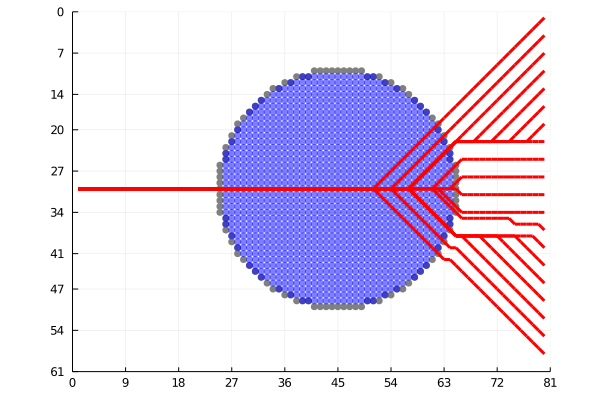

In [9]:
# Define scene
r, w_center, h_center = 20, 45, 30
test_circle = get_circle(r, h_center, w_center)

w,h = 80,60
scene = create_scene(w, h, test_circle, 0.7)

p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
        yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false,
        aspectratio=1, yflip=true)

sources = [(30,1) for k=1:3:60]
sinks = [(k,80) for k=1:3:60]
path = [reconstruct_path(dijkstra(scene, sources[i], sinks[i])[2], sources[i], sinks[i])
    for i=1:length(sources)];

plot_circle(p, r, h_center, w_center)
plot_paths(p, path)
plot(p)

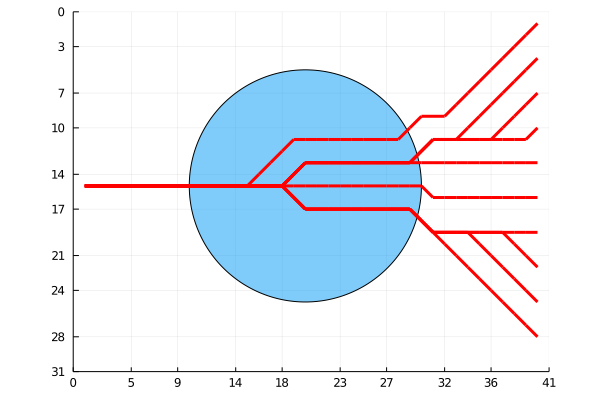

In [10]:
# Define scene
r, w_center, h_center = 10, 20, 15
test_circle = get_circle(r, h_center, w_center)
#test_circle = union(Set(get_circle_perimeter(r, x_center, y_center)),
#                    Set(get_circle_inside(r, x_center, y_center)));
w,h = 40,30
scene = create_scene(w, h, test_circle, 0.7)

p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
        yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false,
        aspectratio=1, yflip=true)

sources = [(15,1) for k=1:3:30]
sinks = [(k,40) for k=1:3:30]
path = [reconstruct_path(dijkstra(scene, sources[i], sinks[i])[2], sources[i], sinks[i])
    for i=1:length(sources)];

plot_circle(p, r, h_center, w_center, false)
plot_paths(p, path)
plot(p)